In [1]:
import pandas as pd
from fastai.vision.all import *
from pathlib import Path
from scipy import io
import os

flowers_path = os.getcwd()

# Identifying 102 categories of flower images using pretrained ResNet-50 CNN model
# Dataset and labels source: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

In [2]:
# Block of code to generate a dictionary of flower names based on the label numbers given in imagelabels.mat
# Text file source: https://www.kaggle.com/datasets/hobaak/oxford-102-flower-name-index
flowers_name=pd.read_csv('Oxford-102_Flower_dataset_labels.txt', names=['name'])

# Removing additional '' and space for each row found within .txt. Otherwise, would get " '<flower_name>'"
flowers_name['name'] = flowers_name['name'].str[2:-1]
flowers_name.index = pd.Index(range(1, 1 + len(flowers_name)))
flowers_name.head(10)
name_dict = flowers_name.to_dict()['name']

In [3]:
# Load image labels from imagelabels.mat MatLab file using scipy.io
mat = io.loadmat('imagelabels.mat')

# List comprehension to create list of string lists with converted index number to filename 
# and converted flower label number to flower name
labels_list = [[f'image_{str(idx).rjust(5, "0")}', name_dict[x]] for idx,x in enumerate(mat["labels"][0],1)]
data = pd.DataFrame(labels_list, columns=['file', 'flower'])
data.tail()

,file,flower
8184,image_08185,japanese anemone
8185,image_08186,japanese anemone
8186,image_08187,japanese anemone
8187,image_08188,japanese anemone
8188,image_08189,japanese anemone


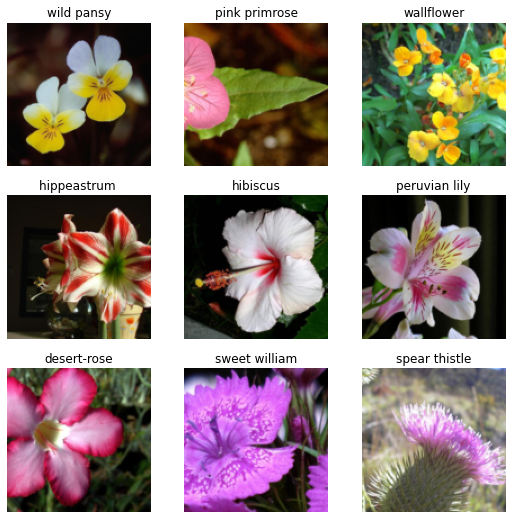

In [4]:
# FastAI API to quickly create tuples of target files and transforms required for ResNet training
flowers = DataBlock(
    # Loads datablocks for image files and label names 
    # ImageBlock for converting PIL Image object to tensor
    # CategoryBlock for converting pandas series to CategoryMap
    blocks=(ImageBlock, CategoryBlock), 
    # Randomly splits 20% of image files and allocates them as the validation set
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # Reads the file column of input pandas DataFrame and uses first column ("file" column found in "data" DataFrame)
    # to generate list of image files for training found within the "jpg" folder
    get_x=ColReader(0, pref=f'{flowers_path}/jpg/', suff='.jpg'), 
    # Reads the file column of input pandas DataFrame and uses second column 
    # ("flower" column found in "data" DataFrame) to generate list of image labels for training
    get_y=ColReader(1)
    # Transformer to resize images to 128 x 128 px as they have varying image dimensions
    ,item_tfms=Resize(128)
)
# Run dataloader method on "flowers" DataBlock to process "data" pandas DataFrame 
# to generate our transformed fileset with corresponding categories for training and validation
dls = flowers.dataloaders(data)
dls.show_batch()

SuggestedLRs(valley=0.0006918309954926372)

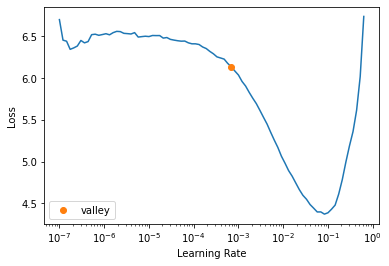

In [5]:
# Use pretrained ResNet-50 model to train on image and category data with error rate as the metric
learn = vision_learner(dls, resnet50, metrics=error_rate)
# Find best learning rate for ResNet-50 training
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time
0,3.218478,1.172229,0.278558,00:14


epoch,train_loss,valid_loss,error_rate,time
0,1.245261,0.696359,0.173488,00:19
1,0.738543,0.427599,0.108125,00:19
2,0.389876,0.369678,0.098351,00:19
3,0.254245,0.357311,0.098351,00:20


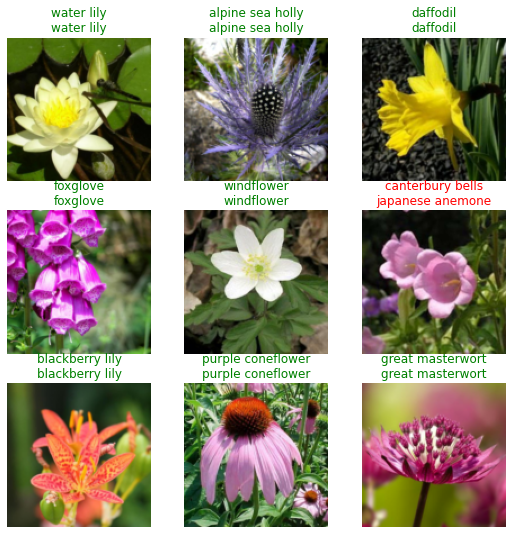

In [6]:
# Using pre-trained model, train on 4 cycles with weights frozen before each cycle and adjusted after the cycle
learn.fine_tune(4, 6e-4)
learn.show_results()

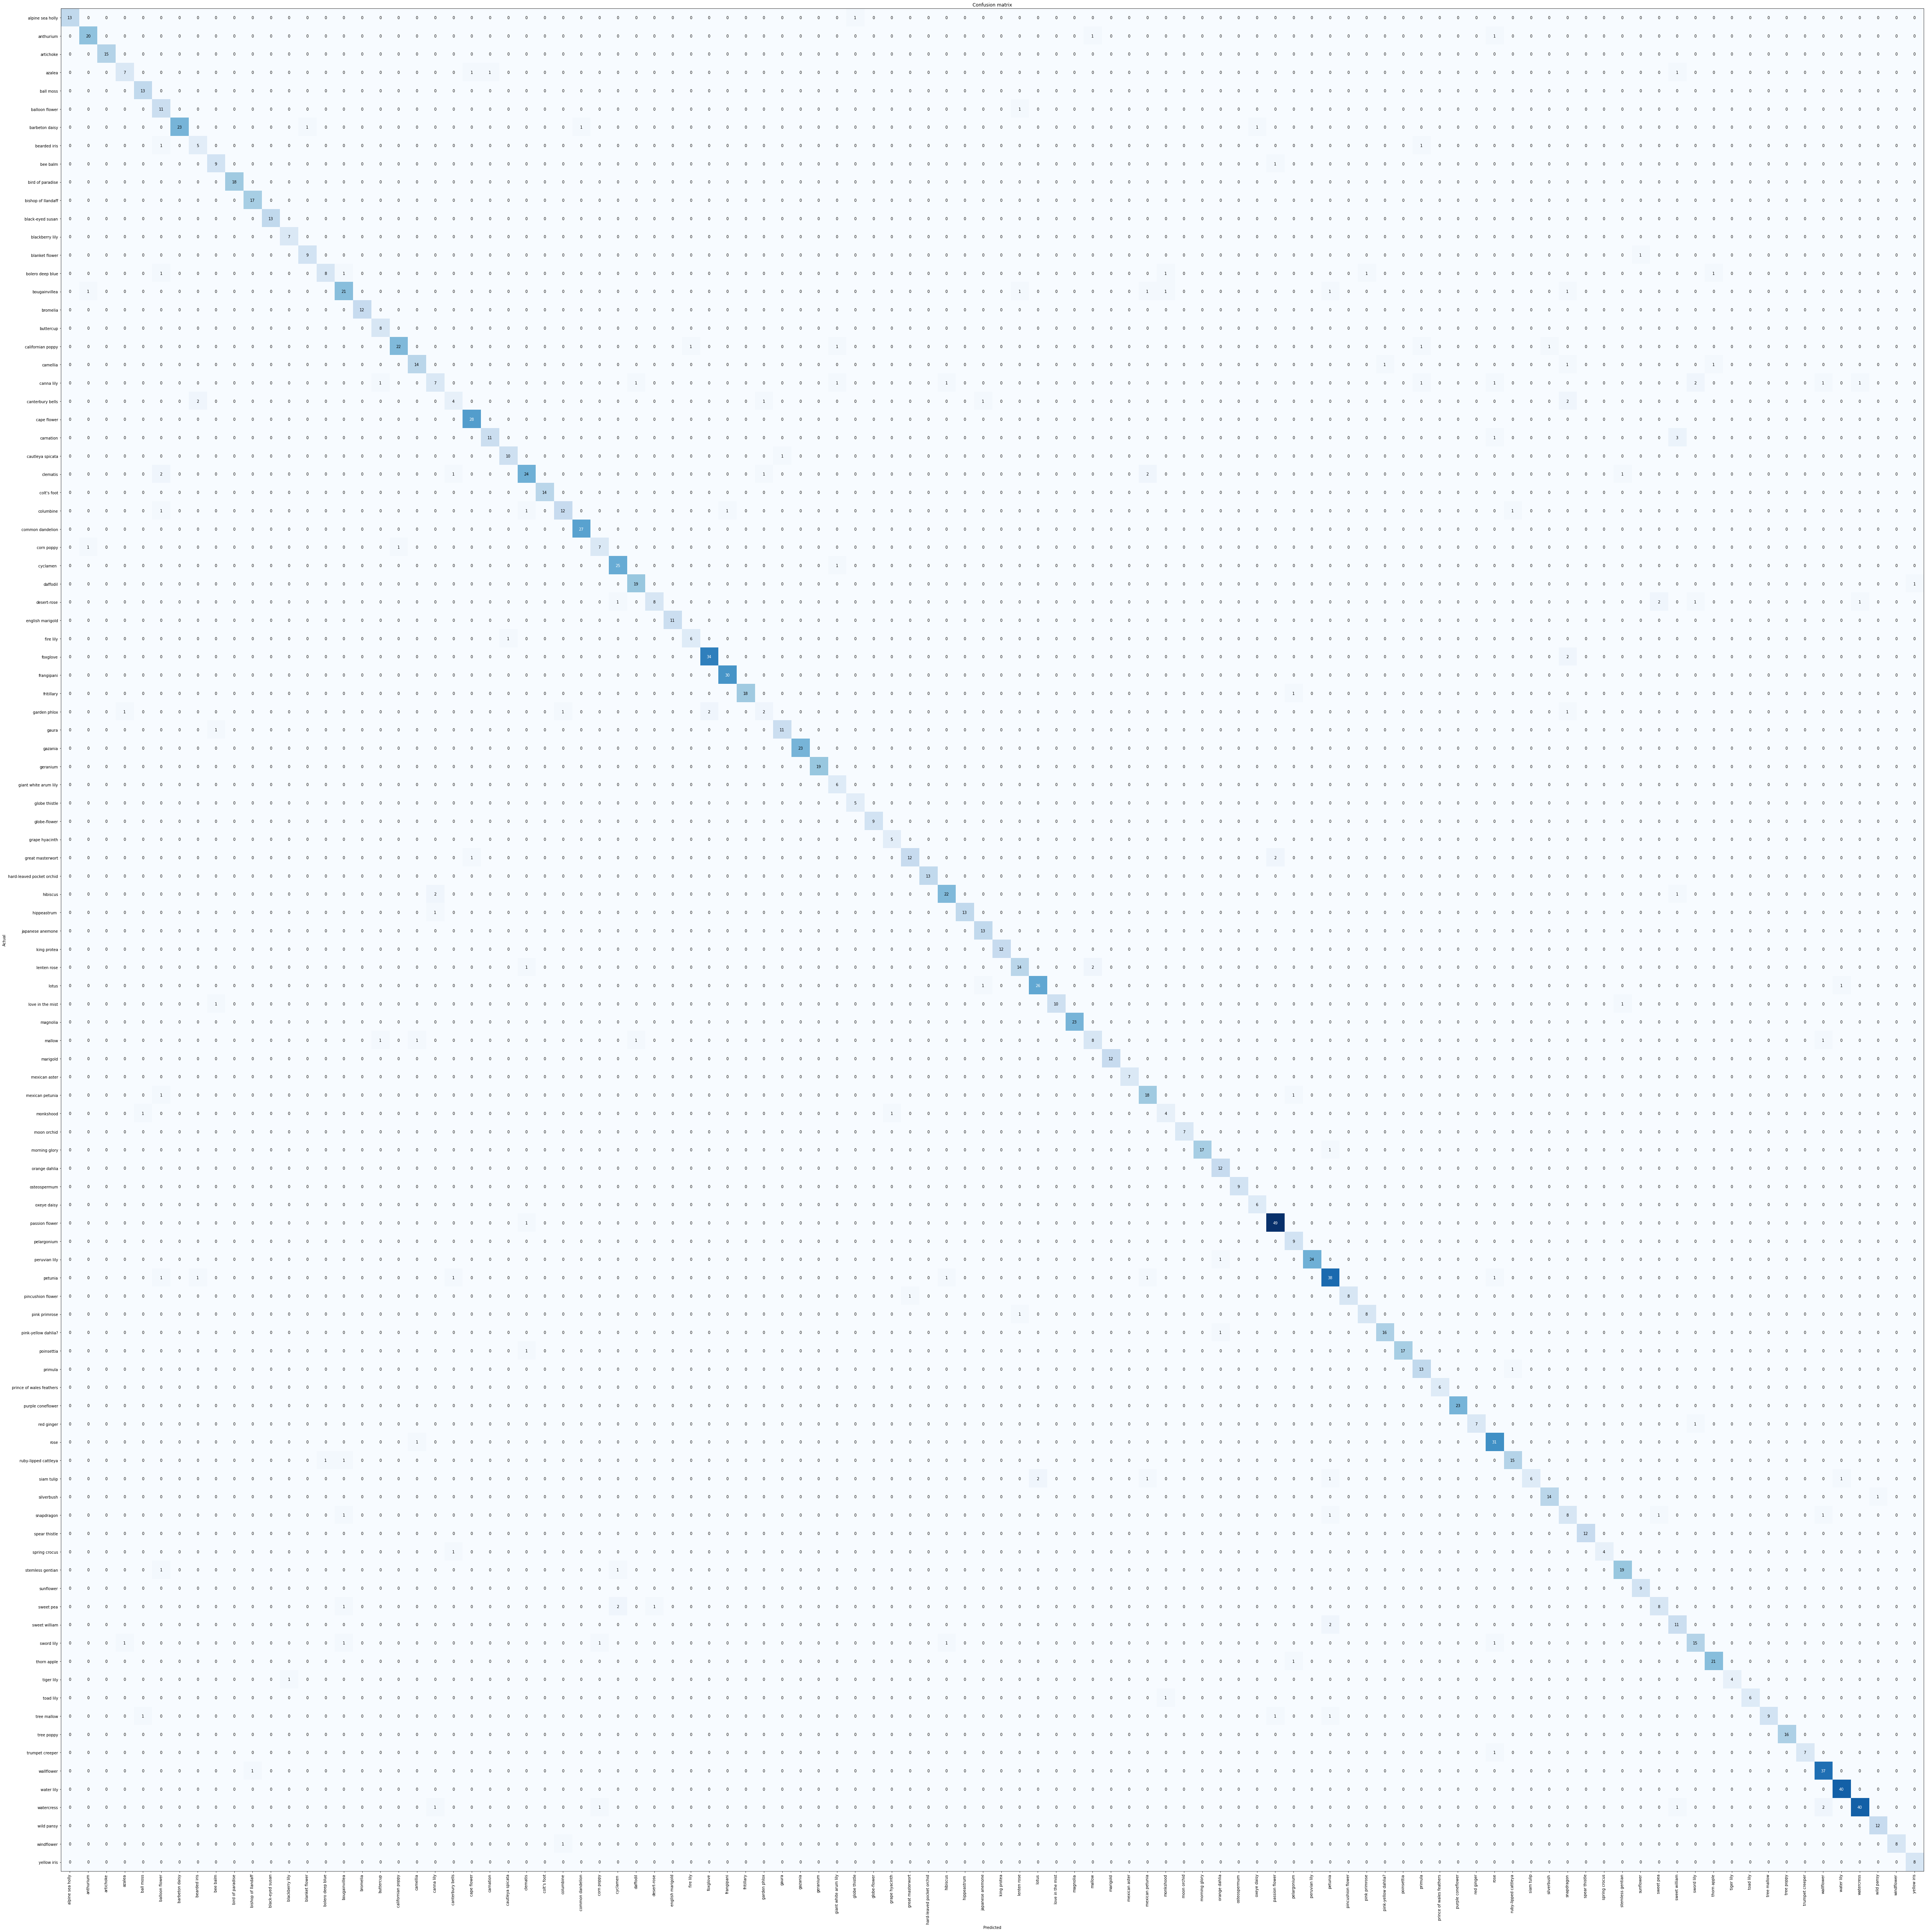

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(70, 70))